# Applying the GP framework (Step 5 to 8)

In [17]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm, uniform, ecdf
import seaborn as sb
from sklearn.cluster import KMeans

## Step 5: Scaling structures

Across input features, the elevation change is well sampled and in many case the features we are interested in are oversampled. This points to the use of sparse variational GPs (see Step 9).

## Step 6: Data transformations

Inference can be improved if the distributions are Gaussian (in order to enforce normal distribution on the posterior distribution) and the data is standardized.

In [14]:
# Load data
train_df = pd.read_csv('data/training_set.csv', index_col=[0])
val_df = pd.read_csv('data/validation_set.csv', index_col=[0])
test_df = pd.read_csv('data/test_set.csv', index_col = [0])

In [74]:
train_df

,elev,ocean_dist,slope,vel,aspect,x,y,dhdt_filt,date_max,date_min,group,dhdt_bc,dhdt_exp,dhdt_filt_aggr,vel_log,slope_log,dhdt_filt_tr,aspect_bc
0,-2.217552,-1.440683,5.197093,35.433570,-0.743231,0.036863,-3.461860,-0.841598,737713.0,732235.0,0,1.102217e+18,0.431021,-1.862717,3.567660,1.648099,-1.779114,1.174971
1,-2.209739,-1.437753,4.037823,60.513220,-0.740294,0.036986,-3.461040,-0.815259,737713.0,732235.0,1,1.131180e+18,0.442525,-1.838340,4.102862,1.395706,-1.715408,1.177576
2,-2.203284,-1.433936,2.551501,57.453743,-0.679223,0.037087,-3.460027,-0.921331,737713.0,732235.0,2,1.018718e+18,0.397989,-1.931382,4.050980,0.936682,-1.971966,1.231641
3,-2.194238,-1.430400,1.833211,53.611755,-0.402978,0.037166,-3.459114,-1.034803,737713.0,732235.0,3,9.100600e+17,0.355296,-2.015901,3.981768,0.606069,-2.246426,1.473672
5,-2.149083,-1.422401,2.072154,42.325912,-0.073936,0.036425,-3.457270,-1.024398,737713.0,732235.0,5,9.195515e+17,0.359012,-2.007703,3.745399,0.728589,-2.221259,1.757083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497133,-2.158810,-1.457382,1.446578,4.157737,-0.948162,1.432855,1.491255,-0.390666,737683.0,731900.0,18718,1.708588e+18,0.676606,-1.276961,1.424971,0.369201,-0.688431,0.991900
497138,-2.155889,-1.459328,2.370549,3.348576,-0.550297,1.432178,1.491672,-0.228664,737683.0,731900.0,18721,1.994208e+18,0.795596,-0.984139,1.208535,0.863122,-0.296590,1.345097
497136,-2.233419,-1.461548,5.596981,1.509064,1.014259,1.426832,1.492113,-0.229011,737471.0,732113.0,875,1.993551e+18,0.795320,-0.984855,0.411490,1.722227,-0.297429,2.663952
497135,-2.235240,-1.461652,5.664680,1.496897,1.023624,1.426780,1.492129,-0.288429,737440.0,732113.0,665,1.883995e+18,0.749440,-1.100921,0.403394,1.734250,-0.441147,2.671584


Text(0.5, 0, 'Elevation change [m/year]')

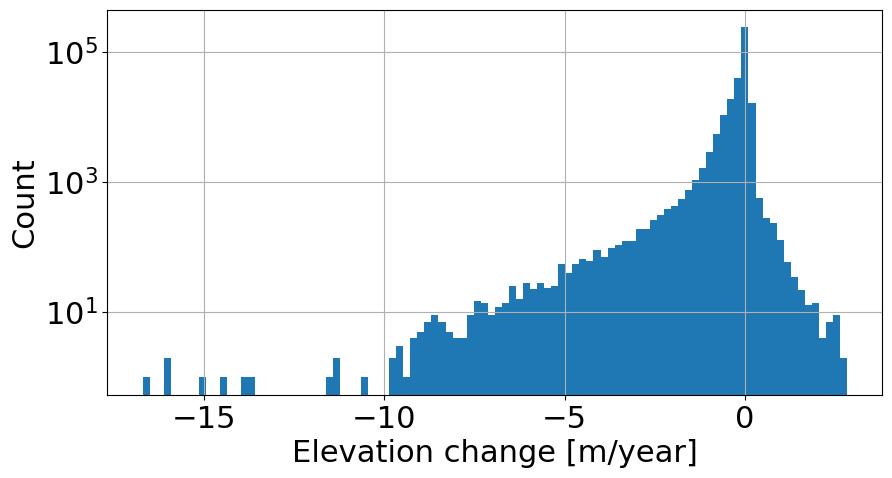

In [7]:
# Probability density function of elevation change
plt.figure(figsize=(10, 5))
train_df['dhdt_filt'].hist(bins=100)
plt.ylabel('Count')
plt.yscale('log')
plt.xlabel('Elevation change [m/year]')

### 6.1. Box-Cox transformation

/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_88248/3023844906.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['dhdt_bc'] = bc_arr


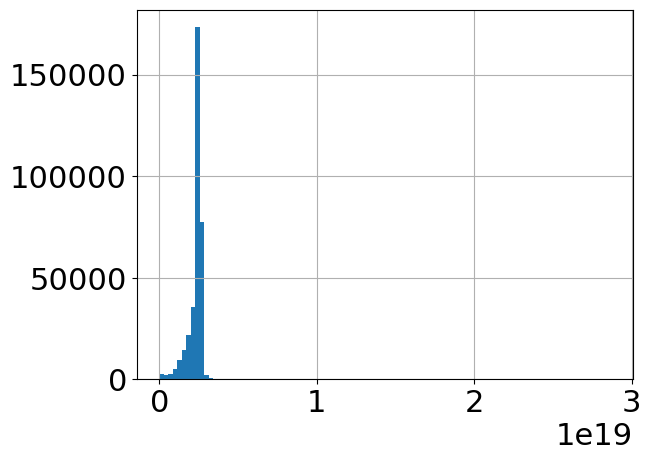

In [70]:
min_change = np.floor(train_df['dhdt_filt'].min())
# make sure data is positive
bc_arr, lmba = stats.boxcox(train_df['dhdt_filt'].values - min_change)
train_df['dhdt_bc'] = bc_arr
train_df['dhdt_bc'].hist(bins=100)

# Repeat for training and validation sets
val_df['dhdt_bc'] = stats.boxcox(val_df['dhdt_filt'], lmbda=lmba)
test_df['dhdt_bc'] = stats.boxcox(test_df['dhdt_filt'], lmbda=lmba)

### 6.2. Log/exp transformation

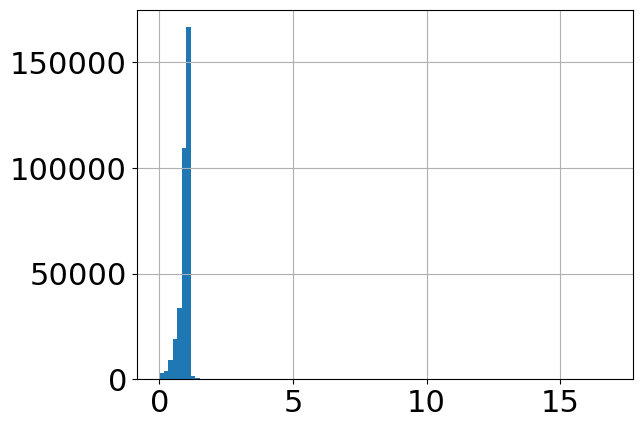

In [52]:
train_df['dhdt_exp'] = np.exp(train_df['dhdt_filt'])
train_df['dhdt_exp'].hist(bins=100)

# Repeat for training and validation sets
val_df['dhdt_exp'] = np.exp(val_df['dhdt_filt'])
test_df['dhdt_exp'] = np.exp(test_df['dhdt_filt'])

### 6.3. Agressive Gaussianization

A possible way to transform the data is by interpolating by sampling it's Cumulative Density Function (CDF) uniformally and then transforming the data to a Gaussian distribution.

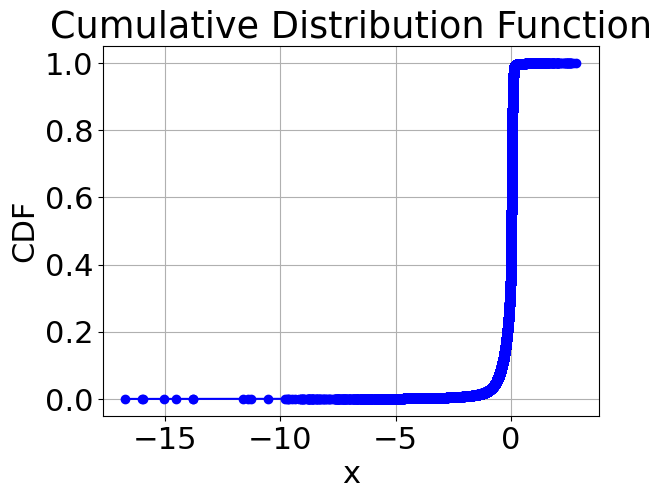

In [122]:
def generate_cdf(data):
    """Generate CDF from data."""
    sorted_data = np.sort(data)
    n = len(sorted_data)
    cdf = np.arange(1, n + 1) / n
    return sorted_data, cdf

# Example usage
data = train_df['dhdt_filt'].values
sorted_data, cdf = generate_cdf(data)

# Plotting the CDF
plt.plot(sorted_data, cdf, marker='o', linestyle='-', color='b')
plt.xlabel('x')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function')
plt.grid(True)
plt.show()

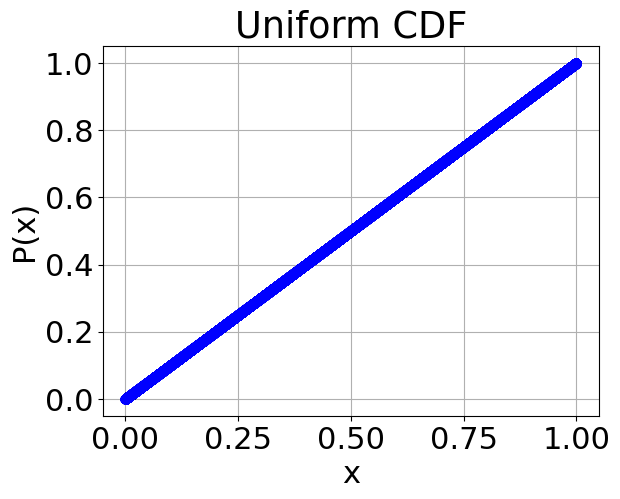

In [123]:
# Plotting the Uniform CDF
p_uniform = uniform.cdf(cdf)
plt.plot(cdf, p_uniform, marker='o', linestyle='-', color='b')
plt.ylabel('P(x)')
plt.xlabel('x')
plt.title('Uniform CDF')
plt.grid(True)
plt.show()

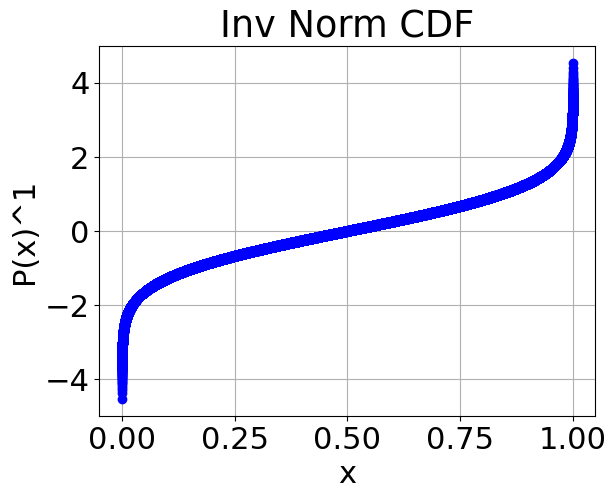

In [97]:
# Plotting the Inverse of the Normal CDF (PPF)
p_norm = norm.ppf(p_uniform)
plt.plot(p_uniform, p_norm, marker='o', linestyle='-', color='b')
plt.ylabel('P(x)^1')
plt.xlabel('x')
plt.title('Inv Norm CDF')
plt.grid(True)
plt.show()

In [98]:
#  Writing out the above as functions

def transform_function(data):
    """ Mapping function"""
    sorted_data = np.sort(data)
    n = len(sorted_data)
    # Empirical CDF
    cdf = np.arange(1, n + 1) / n
    # Gaussian PPF
    p_norm = norm.ppf(cdf)
    return p_norm, sorted_data, cdf

def transform(values, cdf, sorted_data):
    """ data -> uniform -> normal """
    interp_data = np.interp(values, sorted_data, cdf)
    transformed_data = norm.ppf(interp_data)
    return transformed_data

def inv_transform(norm_values, cdf, sorted_data):
    """ normal -> uniform -> data """
    uni_values = norm.cdf(norm_values)
    inverse_transformed_data = np.interp(uni_values, cdf, sorted_data)
    return inverse_transformed_data

In [115]:
train_df.sort_values(by='dhdt_filt', inplace=True)
data = train_df['dhdt_filt'].values
p_norm, sorted_data, cdf = transform_function(data)
p_norm[-1] = 4.54

/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_88248/1227319602.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.sort_values(by='dhdt_filt', inplace=True)


array([[<Axes: title={'center': '0'}>]], dtype=object)

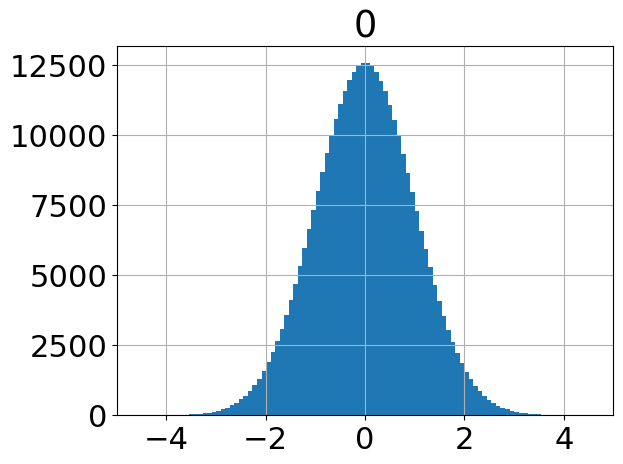

In [119]:
test_y = transform(data, cdf, sorted_data)
test_y[-1] = 4.54
y_test_df = pd.DataFrame(test_y)
y_test_df.interpolate(method='linear', inplace=True)
y_test_df.hist(bins=100)

In [121]:
train_df.sort_values(by='dhdt_filt', inplace=True)
train_df['dhdt_filt_aggr'] = test_y

/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_88248/2644532328.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.sort_values(by='dhdt_filt', inplace=True)
/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_88248/2644532328.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['dhdt_filt_aggr'] = test_y


In [ ]:
# Repeat for training and validation sets
val_df.sort_values(by='dhdt_filt', inplace=True)
val_df['dhdt_aggr'] = transform(val_df['dhdt_filt'], cdf, sorted_data)
test_df.sort_values(by='dhdt_filt', inplace=True)
test_df['dhdt_aggr'] = transform(test_df['dhdt_filt'], cdf, sorted_data)

Text(0.5, 1.0, 'Transformed elevation change')

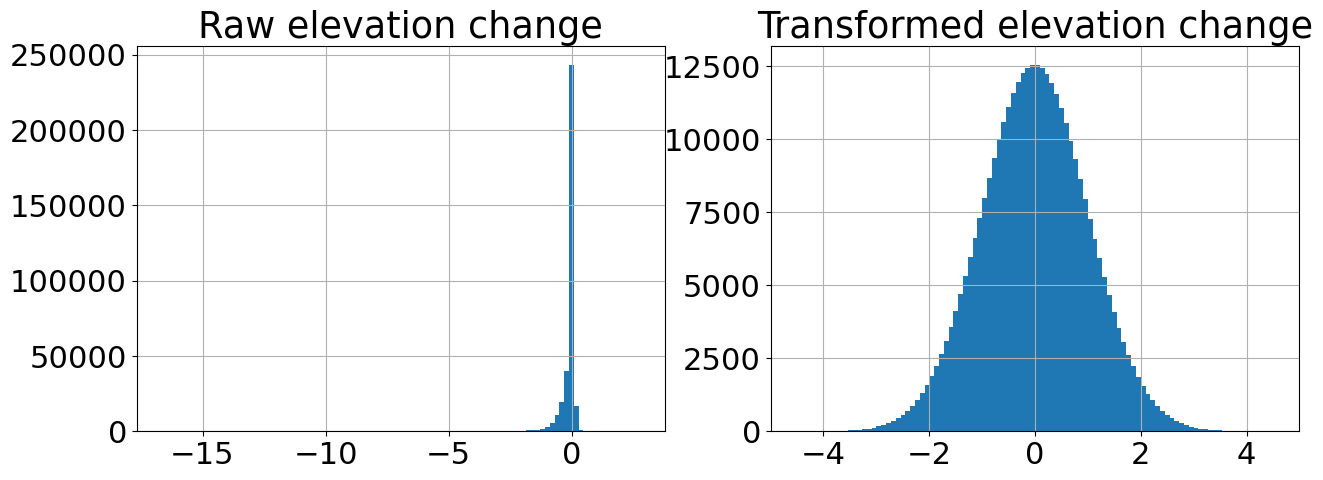

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
train_df['dhdt_filt'].hist(bins=100, ax=ax[0])
#val_df['dhdt_filt'].hist(bins=100, ax=ax[1])
train_df['dhdt_filt_aggr'].hist(bins=100, ax=ax[1])
ax[0].set_title('Raw elevation change')
ax[1].set_title('Transformed elevation change')
#ax[0].set_yscale('log')

### 6.4. Input variable standardisation

From the pairplot in the previous notebook, the velocity and slope values are skewed and aspect is multimodal.

In [82]:
# Transform skewed variables
train_df['vel_log'] = np.log(train_df['vel'])
train_df['slope_log'] = np.log(train_df['slope'])

/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_88248/2790677587.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['vel_log'] = np.log(train_df['vel'])
/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_88248/2790677587.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['slope_log'] = np.log(train_df['slope'])


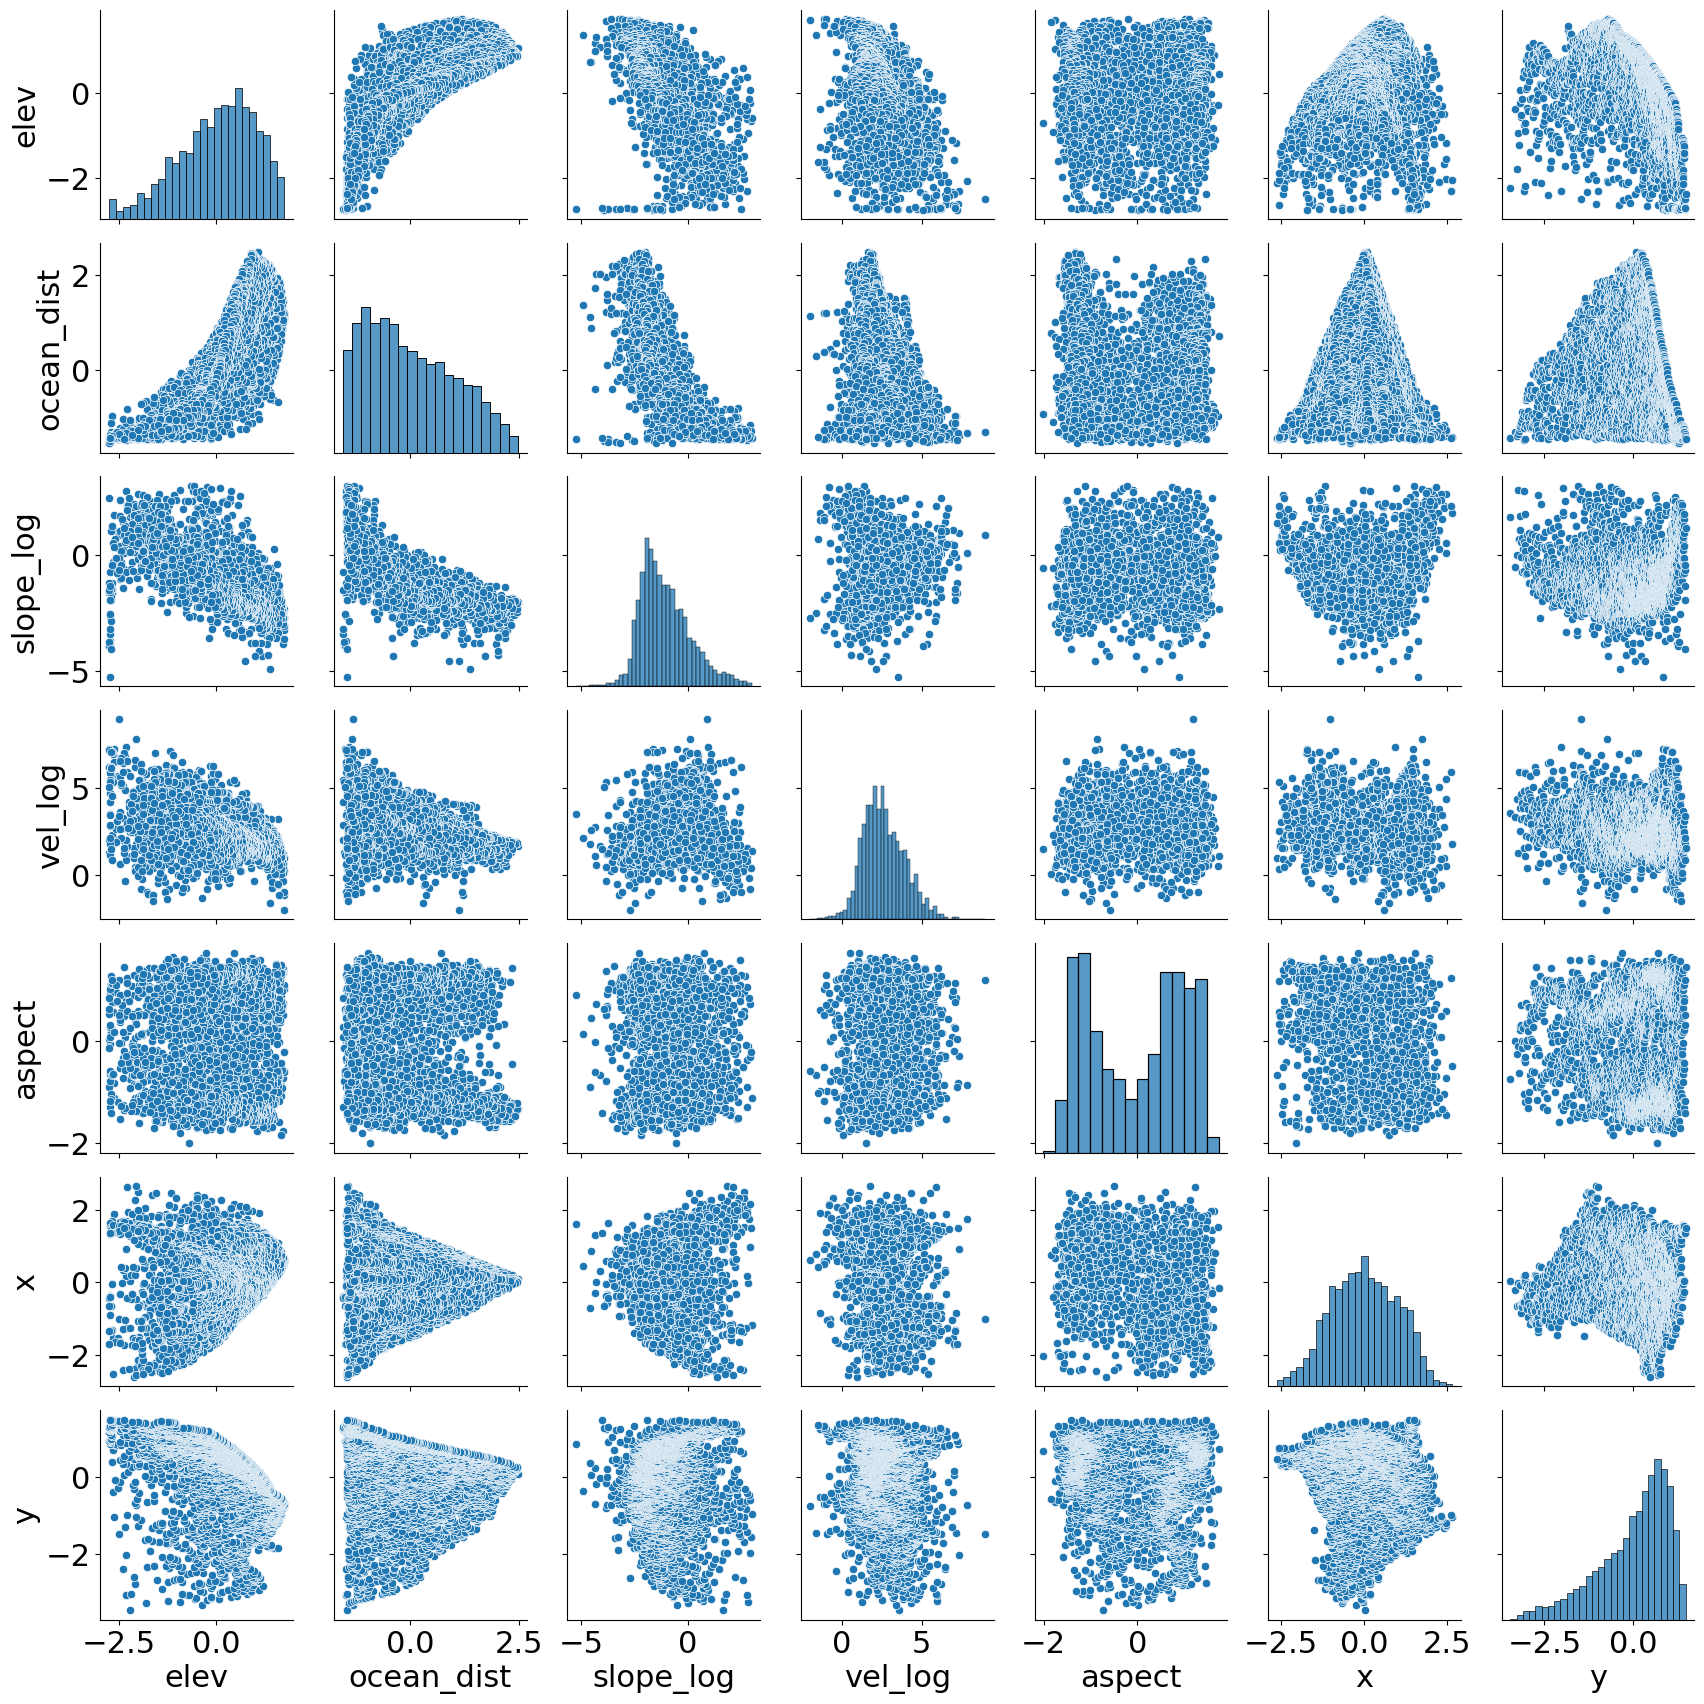

In [83]:
sb.pairplot(train_df[['elev', 'ocean_dist','slope_log', 'vel_log', 'aspect', 'x', 'y']][::100])

In [51]:
# Repeat for training and validation sets
val_df['vel_log'] = np.log(val_df['vel'])
val_df['slope_log'] = np.log(val_df['slope'])

test_df['vel_log'] = np.log(test_df['vel'])
test_df['slope_log'] = np.log(test_df['slope'])

/Users/kenzatazi/miniconda3/envs/gp-frame/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kenzatazi/miniconda3/envs/gp-frame/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [56]:
# Z score the inputs
scaler = StandardScaler().fit(train_df[['elev', 'ocean_dist', 'slope_log', 'vel_log', 'aspect', 'x', 'y', 'dhdt_filt']])
train_df[['elev', 'ocean_dist', 'slope_log', 'vel_log', 'aspect', 'x', 'y', 'dhdt_filt_tr']] = scaler.transform(train_df[['elev', 'ocean_dist', 'slope_log', 'vel_log', 'aspect', 'x', 'y','dhdt_filt']])
val_df[['elev', 'ocean_dist', 'slope_log', 'vel_log', 'aspect', 'x', 'y', 'dhdt_filt_tr']] = scaler.transform(val_df[['elev', 'ocean_dist', 'slope_log', 'vel_log', 'aspect', 'x', 'y', 'dhdt_filt']])
test_df[['elev', 'ocean_dist', 'slope_log', 'vel_log', 'aspect', 'x', 'y', 'dhdt_filt_tr']
        ] = scaler.transform(test_df[['elev', 'ocean_dist', 'slope_log', 'vel_log', 'aspect', 'x', 'y','dhdt_filt']])

In [57]:
train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()

In [58]:
train_df.to_csv('data/training_set_tr.csv')
val_df.to_csv('data/validation_set_tr.csv')
test_df.to_csv('data/test_set_tr.csv')

array([[<Axes: title={'center': 'dhdt_filt_tr'}>]], dtype=object)

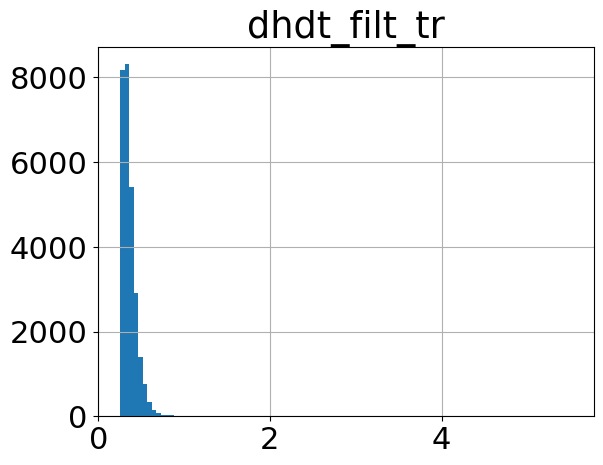

In [59]:
val_df.hist('dhdt_filt_tr', bins=100)

## Step 7: Kernel design

In this section, we try to determine the smoothness, lengthscale, periodicity, outliers and tails, asymmetry, and stationarity of the data.

* **Smoothness**, the overall glacier seems smooth although there are sections with abrupt variations
* **Covariance lenghtscale**, the lengthscale here seems to have stem from two regimes a long lengthscale that acts accross the glacier and some shorter scale varations
* **Periodicity**, none observed.
* **Outliers**, the scatter plots shows that there are some breakaway clusters that do not follow the trend of the rest of the data (in particular for y, elev, slope and vel)
* **Distribution tails**, the histogram for slope even once it is z-scored has a heavy tail.
* **Stationarity**, data looks like it exhibits two modes, high variance-small lengthscale regime near the edges of the glacier and long lengthscale at the centre. 

No obvious periodicity, smooth over central Greenland, smaller lengthscales over the edges.

### More scatter plots

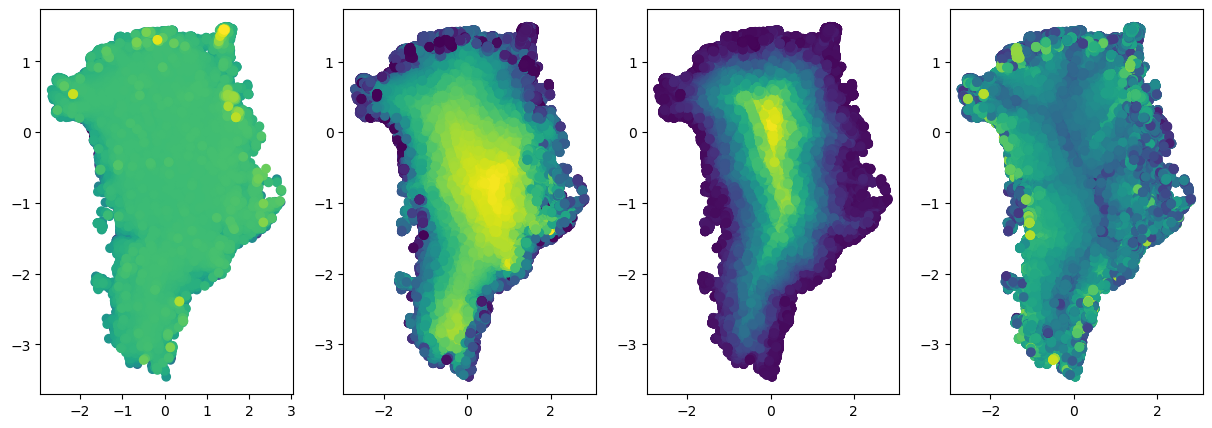

In [116]:
f, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].scatter(x=val_df['x'], y=val_df['y'],
                   c=val_df['dhdt_filt_tr'])
ax[1].scatter(x=train_df['x'], y=train_df['y'],
              c=train_df['elev'])
ax[2].scatter(x=train_df['x'], y=train_df['y'],
              c=train_df['ocean_dist'])
ax[3].scatter(x=train_df['x'], y=train_df['y'],
              c=train_df['vel_log'])

### PCA scatter plot

In [32]:
from sklearn.decomposition import PCA

train_x = train_df[['elev', 'slope_log', 'vel_log', 'aspect', 'x', 'y']]
pca = PCA(n_components=2)
pca.fit(train_x)
print(pca.explained_variance_ratio_)


[0.33246656 0.24440491]


Text(0.5, 1.0, 'PCA of dataset')

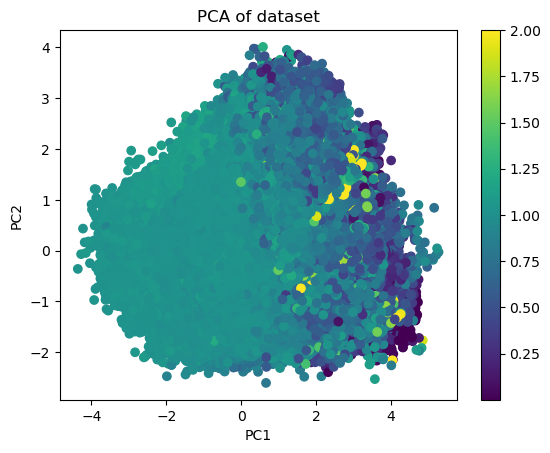

In [37]:
x_r = pca.fit(train_x).transform(train_x)
plt.figure()
plt.scatter(x_r[:, 0], x_r[:, 1], c=train_df['dhdt_filt_exp'], vmax=2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.title("PCA of dataset")


### 1st and 2nd order statistics

In [134]:
print('Mean')
print(train_df[['elev', 'ocean_dist', 'slope_log',
      'vel_log', 'aspect', 'x', 'y']].mean())


Mean
elev         -4.927579e-16
ocean_dist   -1.703684e-16
slope_log     1.048421e-17
vel_log       3.695684e-16
aspect       -8.194884e-17
x            -6.552631e-18
y            -3.669473e-17
dtype: float64


In [135]:
print('Median')
print(train_df[['elev', 'ocean_dist', 'slope_log',
      'vel_log', 'aspect', 'x', 'y']].median())


Median
elev          0.137478
ocean_dist   -0.153076
slope_log    -0.187050
vel_log      -0.097600
aspect        0.215698
x            -0.013408
y             0.256239
dtype: float64


In [136]:
print('Standard deviation')
print(train_df[['elev', 'ocean_dist', 'slope_log',
      'vel_log', 'aspect', 'x', 'y']].std())


Standard deviation
elev          1.000001
ocean_dist    1.000001
slope_log     0.999935
vel_log       1.000001
aspect        1.000001
x             1.000001
y             1.000001
dtype: float64


### Correlation matrix

<Axes: >

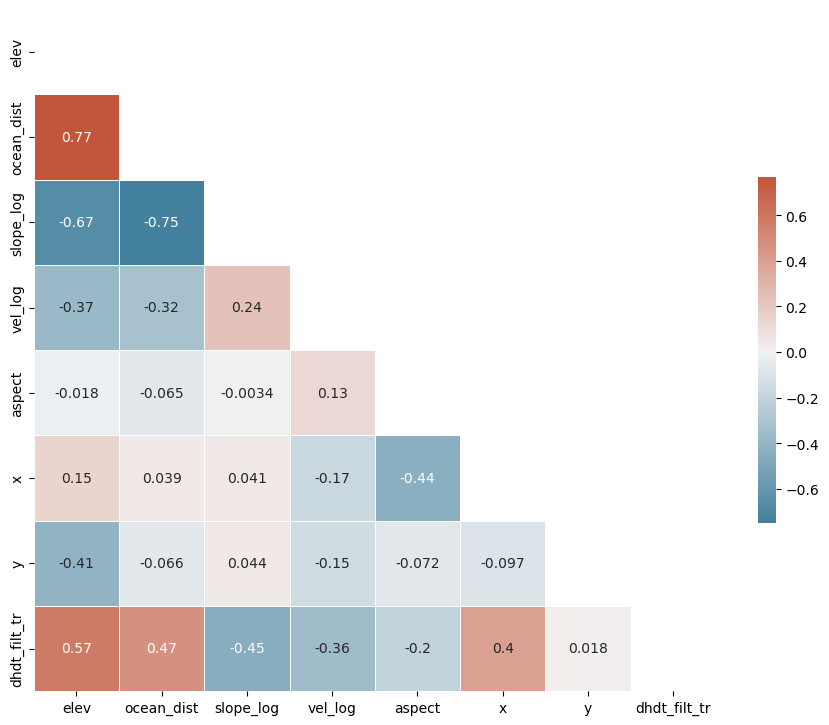

In [121]:
corr = train_df[['elev', 'ocean_dist', 'slope_log', 'vel_log', 'aspect', 'x', 'y', 'dhdt_filt_tr']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sb.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Autocorrelation

The autocorelation plots show no signs of periodicity

/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_88248/3460024199.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.sort_values(by=f[i], inplace=True)
/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_88248/3460024199.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.sort_values(by=f[i], inplace=True)
/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_88248/3460024199.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

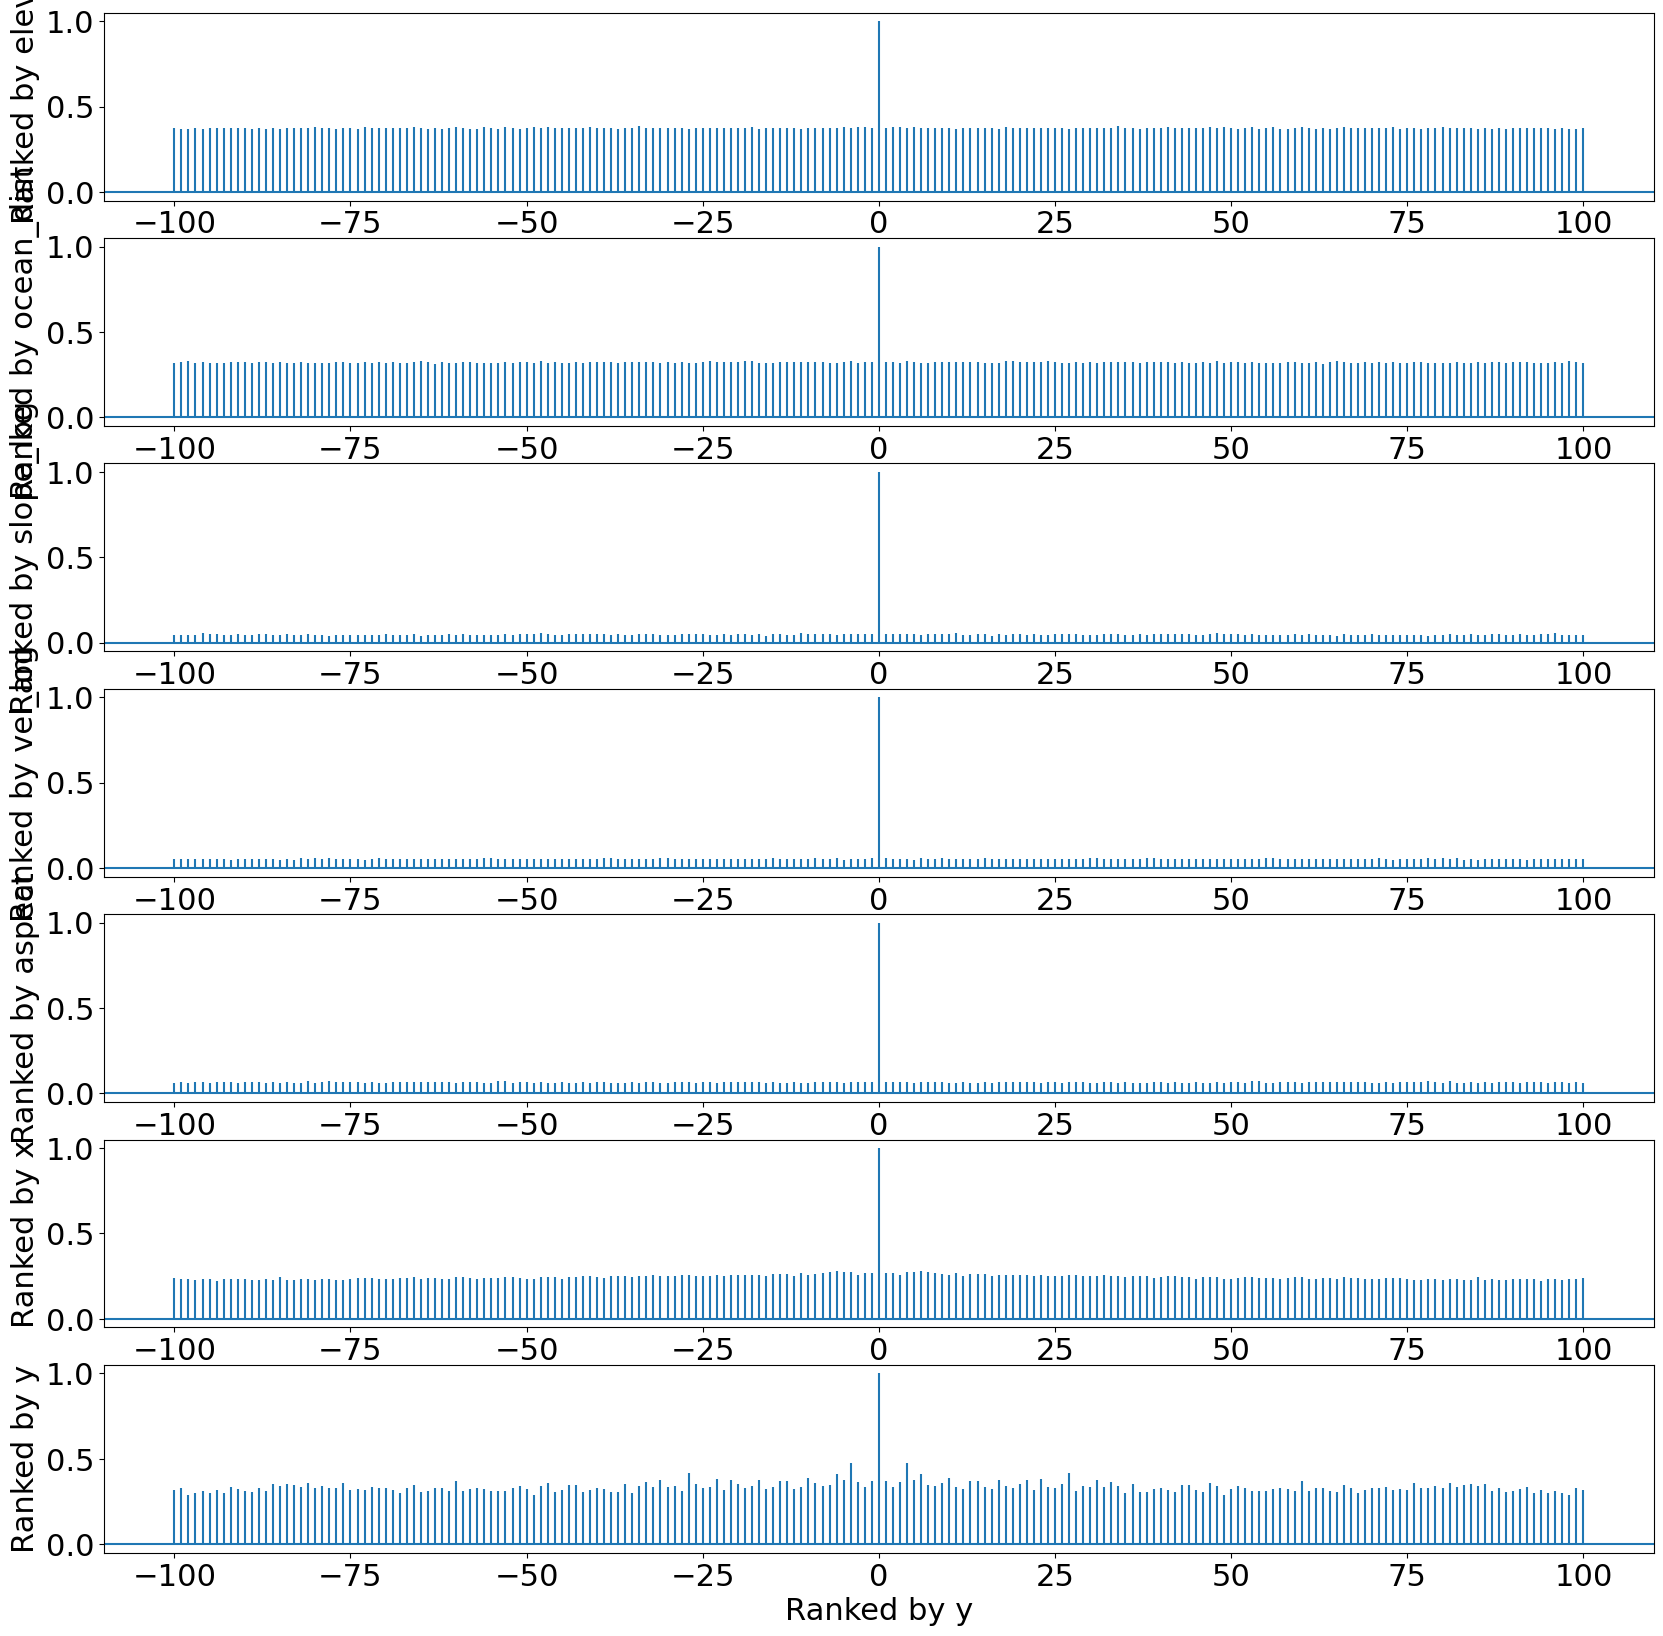

In [61]:

f = ['elev', 'ocean_dist', 'slope_log', 'vel_log', 'aspect', 'x', 'y']

fig, ax = plt.subplots(7, 1, figsize=(20, 20))
for i in range(7):
    train_df.sort_values(by=f[i], inplace=True)
    y = train_df.loc[:1000][['dhdt_filt']].values.flatten()
    ax[i].acorr(y, maxlags=100)
    ax[i].set_xlabel('Ranked by ' + f[i])
    ax[i].set_ylabel('Ranked by ' + f[i])

### K-means

In [96]:
kmeans = KMeans(n_clusters=50, random_state=0,
                n_init="auto").fit(train_df[['x', 'y', 'ocean_dist', ]])
train_df['groups'] = kmeans.labels_

2630


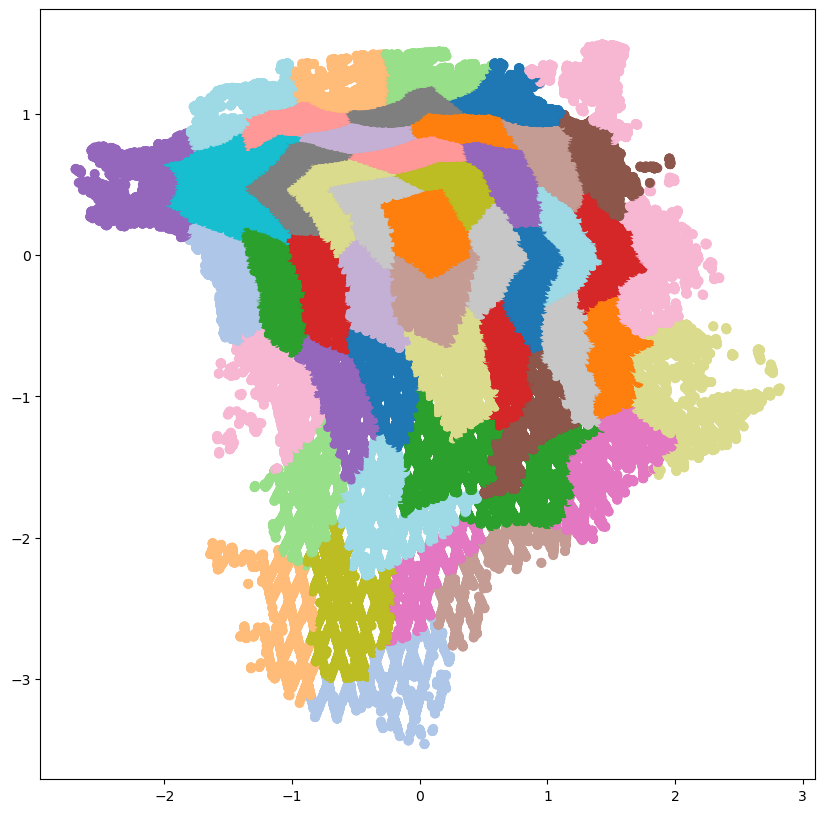

In [97]:
plt.figure(figsize=(10, 10))
plt.scatter(x=train_df['x'], y=train_df['y'],
            c=train_df['groups'], cmap='tab20')
print(train_df['groups'].value_counts().min())